In [514]:
import seaborn as sns # for data visualization
import os
import pprint
import random
import statistics
import scipy.stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob
%matplotlib inline

pp       =  pprint.PrettyPrinter(compact=True)

LOGFILES =  glob.glob('Atlas_kpi_Log_*.json')

print(LOGFILES)

#=== line colors and styles

linestyles = {
    # scenarios
    'empty':        'dotted',
    'canonical':    'dashed',
    'floorplan':    'solid',
     #algorithms
    'Atlas':        'solid',
     #PDRs
    '1':   'solid',
    '0.9': 'solid',
    '0.8': 'solid',
    '0.7': 'solid',
    '0.6': 'solid',
    '0.5': 'solid',
    '0.4': ':',
    '0.3': 'dotted',
    '0.2': '--',
    '0.1': 'dashdot',
}

linecolors = {
    # scenarios
    'empty':        '#262626',
    'canonical':    '#666666',
    'floorplan':    '#ff0000',
    # algorithms
    'Atlas':        '#0000ff',
    # PDRs
     '1':  'royalblue',
     '0.9': 'navy',
     '0.8': 'darkcyan',
     '0.7': 'darkgreen',
     '0.6': 'darkmagenta',
     '0.5': 'r',
     '0.4': 'sienna',
     '0.3': 'firebrick',
     '0.2': 'maroon',
     '0.1': 'purple',
}

#=== helper functions

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m, h)

['Atlas_kpi_Log_210312142529.json']


In [516]:

#=== gather data

log = []
for logfile in LOGFILES:
    with open(logfile,'r') as f:
        for line in f:
            log += [json.loads(line)]
            
lastRunNum = None
runNums    = 0
for run in log:
    if run['runNums']!= lastRunNum:
        runNums      += 1
        lastRunNum    = run['runNums']
            
print('runNums: {} TotalRuns: {}'.format(runNums,len(log)))

runNums: 13 TotalRuns: 13


empty Atlas 45 pdr: 1


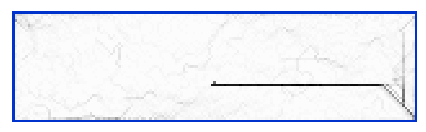

empty Atlas 28 pdr: 0.9


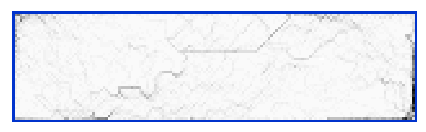

empty Atlas 24 pdr: 0.8


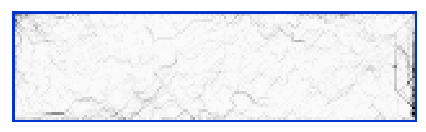

empty Atlas 35 pdr: 0.7


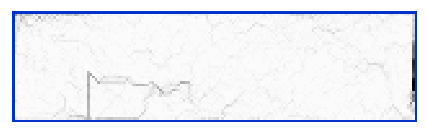

empty Atlas 33 pdr: 0.6


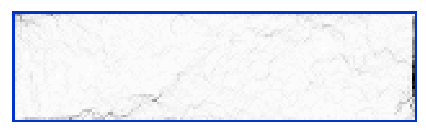

empty Atlas 28 pdr: 0.5


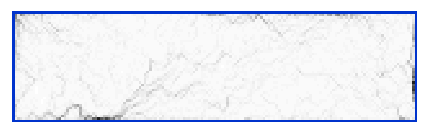

empty Atlas 22 pdr: 0.4


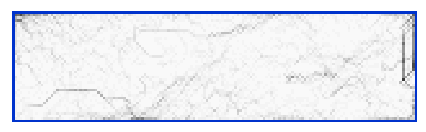

empty Atlas 25 pdr: 0.3


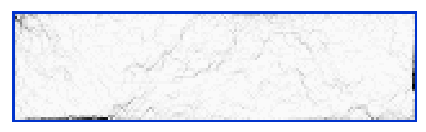

empty Atlas 33 pdr: 0.2


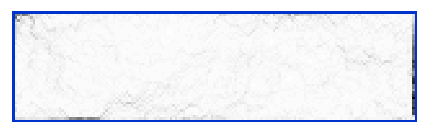

empty Atlas 31 pdr: 0.1


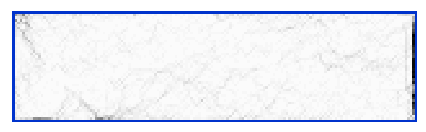

canonical Atlas 36 pdr: 1


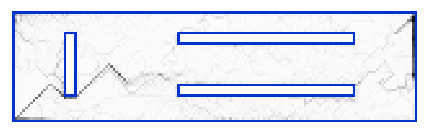

canonical Atlas 28 pdr: 0.9


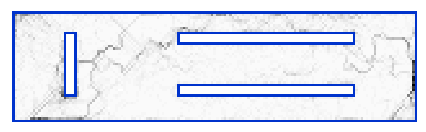

canonical Atlas 46 pdr: 0.8


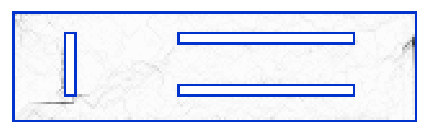

\newcommand{\heatmapMaxNumRobotsemptyAtlas}         {31\xspace}
\newcommand{\heatmapMaxNumRobotscanonicalAtlas}         {46\xspace}


In [517]:
'''
###############################################################################
Heatmap
###############################################################################
'''

#=== create plot

maxNumRobots = {}
plotsgenerated = []

for run in log:
    
    # shorthands
    if run['floorplanType'] == 0:
        scenarioName = 'empty'
    elif run['floorplanType'] == 1:
        scenarioName = 'canonical'
    elif run['floorplanType'] == 2:
        scenarioName = 'floorplan'
     
    navAlg = run['navAlgorithm']
    pdr    = run['pdr']

    # don't plot same data twice
    if (
        ((scenarioName,navAlg) in plotsgenerated) or
        ('heatmap' not in run)
    ):
        continue
    # color cells visited
    data         = np.array(run['heatmap'])
    flat         = data.flatten()
    flat.sort()
    vmax         = flat[-2] # avoid counting num robots on start position
    maxNumRobots[(scenarioName,navAlg)] = vmax
    cmap         = plt.cm.Greys
    norm         = plt.Normalize(0, vmax)
    rgba         = cmap(norm(data))
    
    print(scenarioName,navAlg,vmax,'pdr:',pdr)
    
    # color real map
    realMap      = run['floorplanDrawing']
    x = 0

    for line in realMap.splitlines():
        if not line.startswith('-'):
             continue
        for (y,c) in enumerate(line):
            if   c=='#':
                rgba[x, y, :3] = ( 0/255,  51/255, 204/255)
        x += 1
    
    (fig,ax) = plt.subplots()
    im       = ax.imshow(rgba, interpolation='nearest')

    fig.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.axis('off')
#     fig.savefig(
#         os.path.join(
#             'plots',
#             'heatmap_{0}_{1}.eps'.format(
#                 scenarioName,
#                 navAlg,
#             ),
#         ),
#         bbox_inches='tight',
#     )
    plt.show()
    
    # remember what I have plotted
    #plotsgenerated += [(scenarioName,navAlg)]

for ((scenarioName,navAlg),num) in maxNumRobots.items():
    print('\\newcommand{{\\heatmapMaxNumRobots{}{}}}         {{{}\\xspace}}'.format(scenarioName,navAlg,num))


[2, 2, 1, 1, 1, 1, 1, 1, 1, 1]
min2 [10.883333333333333, 12.216666666666665, 13.9, 16.9, 20.866666666666667, 27.233333333333334, 34.4, 50.13333333333333, 78.76666666666667, 162.56666666666666]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


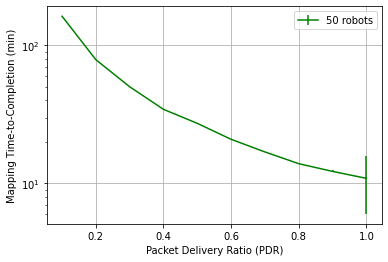

In [509]:
'''
##############################################################################################################
Mapping speed vs PDR for 50 robots 
##############################################################################################################
'''
data_pdr1  = []
data_pdr09 = []
data_pdr08 = []
data_pdr07 = []
data_pdr06 = []
data_pdr05 = []
data_pdr04 = []
data_pdr03 = []
data_pdr02 = []
data_pdr01 = []

for run in log:
    if run['pdr'] == 1:
        data_pdr1 += [run['timeToFullMapping' ]/30]
    if run['pdr'] == 0.9:  
        data_pdr09 += [run['timeToFullMapping']/30]
    if run['pdr'] == 0.8:  
        data_pdr08 += [run['timeToFullMapping']/30]
    if run['pdr'] == 0.7:  
        data_pdr07 += [run['timeToFullMapping']/30]
    if run['pdr'] == 0.6:  
        data_pdr06 += [run['timeToFullMapping']/30]
    if run['pdr'] == 0.5:  
        data_pdr05 += [run['timeToFullMapping']/30]
    if run['pdr'] == 0.4:  
        data_pdr04 += [run['timeToFullMapping']/30]
    if run['pdr'] == 0.3:  
        data_pdr03 += [run['timeToFullMapping']/30]
    if run['pdr'] == 0.2:  
        data_pdr02 += [run['timeToFullMapping']/30]
    if run['pdr'] == 0.1:  
        data_pdr01 += [run['timeToFullMapping']/30]
     
(m1,h1)  =mean_confidence_interval(data_pdr1)
(m09,h09)=mean_confidence_interval(data_pdr09)
(m08,h08)=mean_confidence_interval(data_pdr08)
(m07,h07)=mean_confidence_interval(data_pdr07)
(m06,h06)=mean_confidence_interval(data_pdr06)
(m05,h05)=mean_confidence_interval(data_pdr05)
(m04,h04)=mean_confidence_interval(data_pdr04)
(m03,h03)=mean_confidence_interval(data_pdr03)
(m02,h02)=mean_confidence_interval(data_pdr02)
(m01,h01)=mean_confidence_interval(data_pdr01)  
datas = [data_pdr1,
data_pdr09,
data_pdr08,
data_pdr07,
data_pdr06,
data_pdr05,
data_pdr04,
data_pdr03,
data_pdr02,
data_pdr01]
num_points = [len(data) for data in datas ]
print(num_points)
y = [m1,m09,m08,m07,m06,m05,m04,m03,m02,m01]
print('min2',y)
x = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
yerr= [h1,h09,h08,h07,h06,h05,h04,h03,h02,h01]

#=== create plot
(fig,ax) = plt.subplots()
ax.errorbar(x, y, yerr=yerr,color='green', label = "50 robots")
ax.grid(True, zorder=100)
plt.legend(loc='upper right', fontsize=10, bbox_to_anchor= (1.00, 1.00))
plt.yscale('log')
#plt.title("PDR vs. Mapping Time-to-Completion")
plt.xlabel("Packet Delivery Ratio (PDR)")
plt.ylabel("Mapping Time-to-Completion (min)")
plt.savefig('PDR_vs_time_all_2.eps')


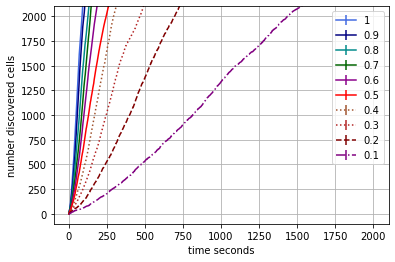

KeyError: '0.8'

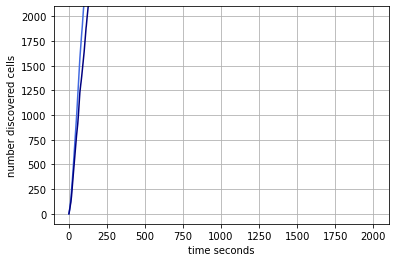

In [510]:
'''
###############################################################################
Mapping Profile
###############################################################################
'''

#=== gather data

data               = {}
scenarioNames      = []
allNumRobots       = []
for run in log:
    if run['floorplanType'] == 0:
        scenarioName = 'empty'
    elif run['floorplanType'] == 1:
        scenarioName = 'canonical'
    elif run['floorplanType'] == 2:
        scenarioName = 'floorplan'
    scenarioNames += [scenarioName]
    
    navAlg = run['navAlgorithm'] 
    pdr    = run['pdr']
    numDotBots      = run['numDotBots']
    allNumRobots  += [numDotBots]
    profile        = run['profile']
    if (scenarioName,numDotBots) not in data:
        data[(scenarioName,numDotBots)] = {}
    if pdr not in data[(scenarioName,numDotBots)]:
        data[(scenarioName,numDotBots)][pdr] = []
    data[(scenarioName,numDotBots)][pdr] += [profile]

for (k1,v1) in data.items():
    for (k2,profiles) in v1.items():
        maxlen  = max(len(p) for p in profiles)
        ms      = []
        hs      = []
        for i in range(maxlen):
            l = []
            for p in profiles:
                try:
                    l += [p[i]]
                except IndexError:
                    pass
            (m,h) = mean_confidence_interval(l)
            ms += [m]
            hs += [h]
        data[k1][k2] = {
            'mean':                ms,
            'confidence_interval': hs,
        }
    
#=== create plot

scenarioNames = set(scenarioNames)
allNumRobots  = set(allNumRobots)

for scenarioName in scenarioNames:
    (fig,ax) = plt.subplots()
    lines    = {}
    for ((scenario,numRobots),v) in data.items():
        if numDotBots!=50:
            continue
        if scenario!=scenarioName:
            continue
        for (pdr,profile) in v.items():
            x             = range(len(profile['mean']))
            y             = profile['mean']
            yerr          = profile['confidence_interval']
            lines[str(pdr)] = ax.errorbar(x=x,y=y,yerr=yerr,color=linecolors[str(pdr)],linestyle=linestyles[str(pdr)],label=pdr)
    ax.grid(True, zorder=5)
    plt.xlabel('time seconds')
    plt.xlim(-100,2100)
    plt.ylabel('number discovered cells')
    plt.ylim(-100,2100)
    plt.legend(handles=[lines['1'],lines['0.9'],lines['0.8'],lines['0.7'], lines['0.6'],lines['0.5'],lines['0.4'],lines['0.3'], lines['0.2'],lines['0.1']])
    plt.show()
    #fig.savefig(os.path.join('plots','mapping_profile_{0}.eps'.format(scenarioName)),bbox_inches='tight')